# Evolutionary Computation - Assignment 5 Report

* Kajetan Sulwiński 151954
* Mikołaj Marmurowicz 151956

## Imports

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib import MatplotlibDeprecationWarning
import warnings

## Problem instance reading and cost scaling

In [2]:
dfTSPA = pd.read_csv('.\\TSPA.csv', sep=';', names=['X', 'Y', 'Cost'])
dfTSPB = pd.read_csv('.\\TSPB.csv', sep=';', names=['X', 'Y', 'Cost'])

min_cost_A = dfTSPA['Cost'].min()
max_cost_A = dfTSPA['Cost'].max()
dfTSPA['Normalized_Cost'] = (dfTSPA['Cost'] - min_cost_A) / (max_cost_A - min_cost_A)

min_cost_B = dfTSPB['Cost'].min()
max_cost_B = dfTSPB['Cost'].max()
dfTSPB['Normalized_Cost'] = (dfTSPB['Cost'] - min_cost_B) / (max_cost_B - min_cost_B)

## Problem description

### Problem

We were to find a cycle that consisted of exactly 50% of the available nodes, where each node had its own cost along with x and y coordinates. The objective function was a sum of node costs and distances (Euclidean) between each traveled node. 

### Solution implementation

We have added an improved method for Local Search created in the previous laboratories in C++.


* **Local Search with the use of move evaluations from previous iterations**

    * **Input:**
        - `cycle` : An array of a previously generated cycle
        - `costDistanceInfo` : A symmetric matrix of distances and costs between nodes

    * **Output:**
        - An array of new `cycle` node IDs

    * **Function:**

        ```python
        FUNCTION generateCycle(start_pos)
            INITIALIZE currentCycle AS a COPY of initialCycle
            INITIALIZE positionInCycleCache[SIZE of costDistanceInfo] TO -1
            # Populate cache with initial cycle positions
            FOR EACH nodeId IN currentCycle
                positionInCycleCache[nodeId] = nodeId’s index IN currentCycle
            DO
                moveFound = False
                possibleMoves = EMPTY SET
                enteringNodesIds = ALL nodes IN currentCycle
                # Generate all moves
                CALL generateMoves(possibleMoves, currentCycle, positionInCycleCache, enteringNodesIds)
                enteringNodesIds = EMPTY
                # Evaluate and apply the best move
                FOR EACH move IN possibleMoves
                    IF move.isApplicable(currentCycle, positionInCycleCache)
                        move.performMove(currentCycle, positionInCycleCache)
                        # Update cache after move
                        UPDATE positionInCycleCache USING move
                        moveFound = True
                        enteringNodesIds = move.getEnteringIds()
                        BREAK
                    ELSE IF NOT move.shouldBeLeftInLM(currentCycle, positionInCycleCache)
                        REMOVE move FROM possibleMoves
                # Clean up invalid or applied moves
                REMOVE ALL invalid moves FROM possibleMoves
            UNTIL NOT moveFound
            RETURN currentCycle

        ```

        ```python
        FUNCTION generateMoves(movesList, currentCycle, positionInCycleCache, enteringNodesIds)
            INITIALIZE indicesNotInCycle AS EMPTY LIST
            FOR i FROM 0 TO costDistanceInfo.SIZE
                # Use cache to find nodes not in the current cycle
                IF positionInCycleCache[i] == -1
                    APPEND i TO indicesNotInCycle
            # Generate Inter Moves
            FOR EACH nodeNotInCycleId IN indicesNotInCycle
                FOR EACH nodeInCycle IN enteringNodesIds
                    CREATE InterNodeNeighbourhoodMove(nodeInCycle, nodeNotInCycleId)
                    CALCULATE functionDelta FOR move USING costDistanceInfo AND cache
                    IF functionDelta < 0
                        ADD move TO movesList
            # Generate Intra Moves
            FOR EACH enteringId IN enteringNodesIds
                enteringIdCyclePos = positionInCycleCache[enteringId]
                enteringIdSuccId = currentCycle[(enteringIdCyclePos + 1) % SIZE of currentCycle]
                FOR EACH nodeInCycleId IN currentCycle
                    nodeInCyclePos = positionInCycleCache[nodeInCycleId]
                    nodeInCycleSuccId = currentCycle[(nodeInCyclePos + 1) % SIZE of currentCycle]
                    IF INVALID move pairing CONTINUE
                    CREATE IntraNodeChangeEdgeNeighbourhoodMove(enteringId, nodeInCycleId, enteringIdSuccId, nodeInCycleSuccId)
                    CALCULATE functionDelta FOR move USING costDistanceInfo AND cache
                    IF functionDelta < 0
                        ADD move AND reversedMove TO movesList
        ```

## Presenting the results

### Results presented as minimum, average and maximum of objective function

Presented in a table below, each method and each problem instance is shown.

In [3]:
file_paths = ['.\\TSPA_DeltaLocalSearch.csv', '.\\TSPA_NormalLocalSearch.csv', '.\\TSPA_Random.csv',
              '.\\TSPB_DeltaLocalSearch.csv', '.\\TSPB_NormalLocalSearch.csv', '.\\TSPB_Random.csv'] 
methods = ['LS with delta moves evaluation', 'Steepest LS', 'Random']
results = []
best_solutions = []
counter = 0
for file_path, method in zip(file_paths, methods * 2):
    df = pd.read_csv(file_path)
    costs = df.iloc[:, -1]
    minimum = costs.min()
    maximum = costs.max()
    mean = round(costs.mean(), 2)
    if counter < len(methods):
        results.append((method, 'TSPA', f"{mean} ({minimum} - {maximum})"))
    else:
        results.append((method, 'TSPB', f"{mean} ({minimum} - {maximum})"))
    if '..' not in file_path:
        min_sol = df.loc[costs.idxmin()][:-1].to_list()
        best_solutions.append(min_sol)
    counter += 1
result_df = pd.DataFrame(results, columns=['Method', 'Column', 'Value'])
result_df = result_df.pivot(index='Method', columns='Column', values='Value')
result_df.columns.name = None
result_df

,TSPA,TSPB
Method,,
LS with delta moves evaluation,74185.58 (71220 - 79601),48743.82 (45480 - 52232)
Random,265574.29 (232959 - 297744),213112.96 (184247 - 233038)
Steepest LS,73852.09 (71654 - 78313),48379.05 (45987 - 51946)


Aditional information regarding the running time of each method (in milliseconds).

In [4]:
methods_for_times = [['Steepest LS','LS with delta moves evaluation']]
times_files = ['.\\times.csv']

results_times = []
for method_list, time_file in zip(methods_for_times, times_files):
    df_temp = pd.read_csv(time_file, header=None).iloc[:, :-1]
    counter = 0
    for column, method in zip(df_temp.columns, method_list * 2):
        min_value = df_temp[column].min()
        max_value = df_temp[column].max()
        avg_value = df_temp[column].mean()
        if counter < len(method_list):
            results_times.append((method, 'TSPA', f"{round(avg_value, 4)} ({round(min_value, 4)} - {round(max_value, 4)})"))
        else:
            results_times.append((method, 'TSPB', f"{round(avg_value, 4)} ({round(min_value, 4)} - {round(max_value, 4)})"))
        counter += 1

times_df = pd.DataFrame(results_times, columns=['Method', 'Column', 'Value'])
times_df = times_df.pivot(index='Method', columns='Column', values='Value')
times_df.columns.name = None  
times_df

,TSPA,TSPB
Method,,
LS with delta moves evaluation,39.1744 (30.066 - 54.5994),39.4872 (29.6452 - 68.6829)
Steepest LS,144.6746 (126.956 - 176.132),145.4435 (129.16 - 172.586)


### Visualization of the best path for each method

Additionally, a list of node indices is presented.

LS with delta moves evaluation
TSPA
[48, 54, 177, 10, 4, 112, 123, 149, 65, 116, 59, 118, 51, 151, 133, 162, 194, 127, 70, 135, 154, 180, 158, 53, 26, 86, 75, 101, 1, 97, 152, 2, 129, 120, 44, 25, 16, 171, 175, 113, 56, 31, 157, 196, 81, 90, 165, 119, 40, 185, 179, 145, 78, 92, 57, 55, 52, 106, 178, 3, 14, 144, 49, 102, 62, 9, 148, 94, 63, 122, 79, 80, 176, 137, 23, 89, 183, 143, 0, 117, 93, 140, 108, 18, 22, 146, 181, 159, 193, 41, 139, 68, 46, 198, 115, 42, 43, 184, 160, 34]
0 3
TSPB
[61, 91, 141, 77, 81, 153, 187, 163, 103, 89, 127, 137, 114, 113, 176, 194, 166, 86, 185, 179, 94, 47, 148, 60, 20, 28, 149, 140, 183, 152, 170, 34, 55, 18, 62, 128, 124, 106, 143, 35, 109, 0, 29, 160, 33, 144, 111, 82, 21, 8, 104, 138, 168, 195, 145, 15, 3, 70, 13, 132, 169, 188, 6, 147, 191, 90, 125, 51, 98, 118, 25, 158, 121, 131, 122, 135, 63, 38, 27, 16, 1, 156, 198, 117, 193, 31, 54, 164, 73, 136, 190, 80, 162, 175, 78, 142, 45, 5, 177, 36]


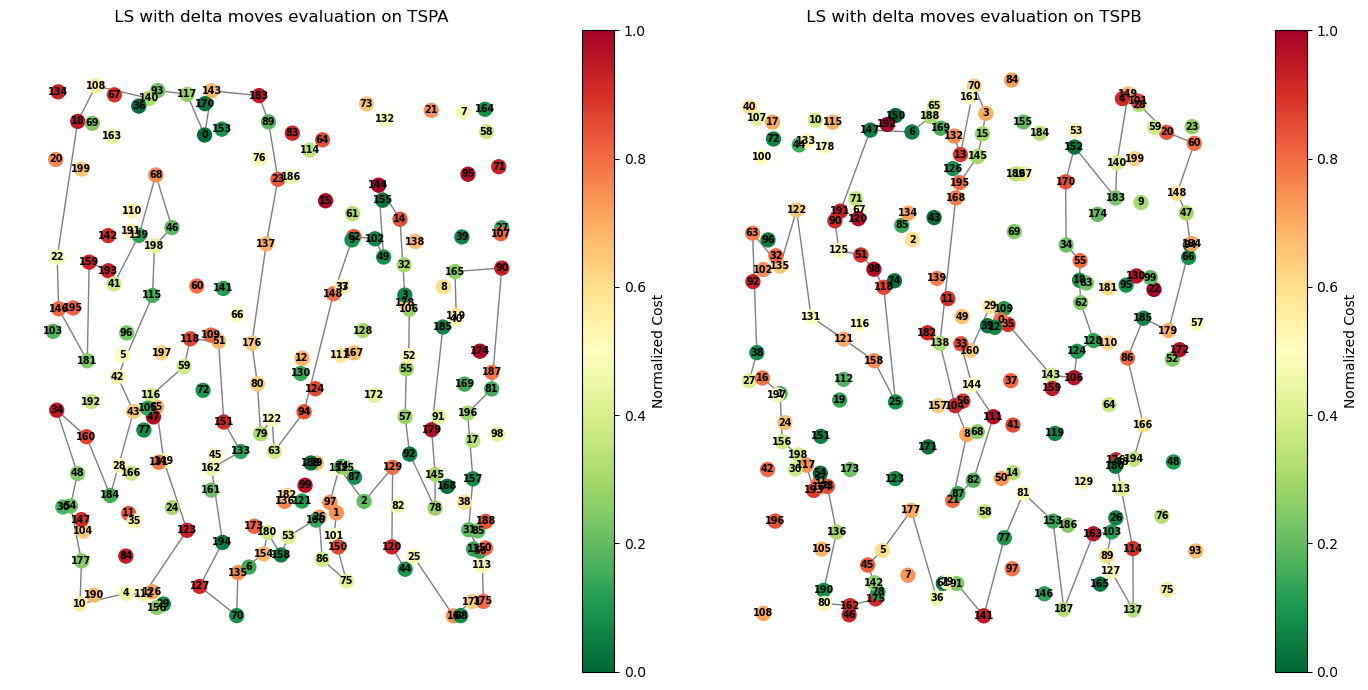

Steepest LS
TSPA
[44, 16, 171, 175, 113, 56, 31, 157, 196, 81, 90, 27, 164, 39, 165, 119, 40, 185, 55, 52, 106, 178, 3, 14, 49, 102, 144, 62, 9, 148, 137, 23, 186, 89, 183, 143, 0, 117, 93, 108, 18, 22, 159, 193, 41, 139, 46, 115, 59, 149, 131, 65, 116, 43, 42, 181, 34, 160, 48, 54, 177, 10, 190, 184, 84, 112, 123, 127, 70, 135, 162, 118, 51, 176, 80, 151, 133, 79, 122, 124, 94, 63, 180, 154, 53, 100, 26, 97, 152, 1, 101, 86, 75, 2, 129, 57, 92, 145, 78, 120]
1 4
TSPB
[136, 190, 80, 162, 175, 78, 142, 45, 5, 177, 104, 8, 82, 87, 21, 61, 36, 141, 97, 77, 81, 111, 144, 33, 160, 29, 0, 109, 35, 143, 124, 106, 153, 187, 163, 165, 127, 89, 103, 113, 176, 194, 166, 86, 185, 95, 130, 99, 179, 94, 47, 148, 60, 20, 28, 149, 4, 199, 140, 183, 174, 55, 18, 62, 34, 170, 152, 184, 155, 3, 70, 15, 145, 132, 169, 188, 6, 13, 195, 168, 139, 11, 138, 182, 25, 121, 51, 90, 122, 133, 107, 40, 63, 135, 1, 117, 193, 31, 54, 73]


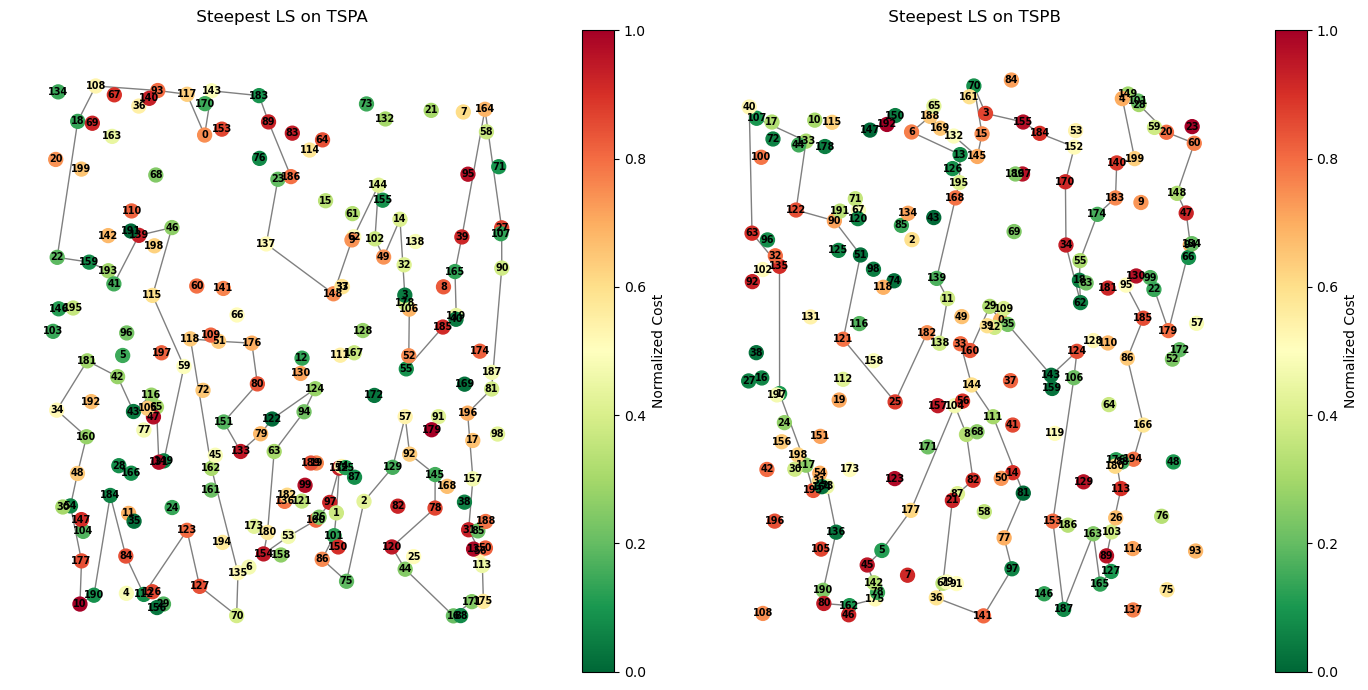

Random
TSPA
[48, 169, 113, 152, 82, 49, 4, 63, 96, 135, 175, 84, 12, 161, 32, 110, 30, 133, 57, 131, 10, 47, 40, 136, 44, 112, 159, 199, 118, 151, 178, 124, 122, 70, 71, 179, 181, 93, 75, 53, 198, 194, 5, 24, 89, 134, 167, 27, 94, 141, 79, 127, 97, 26, 100, 6, 111, 37, 166, 184, 80, 139, 74, 146, 138, 31, 72, 170, 25, 92, 29, 154, 172, 45, 180, 197, 116, 54, 165, 42, 137, 143, 13, 35, 191, 149, 68, 140, 55, 14, 0, 185, 51, 95, 33, 128, 2, 87, 60, 43]
2 5
TSPB
[11, 182, 83, 99, 74, 132, 2, 35, 80, 193, 38, 103, 172, 34, 77, 18, 152, 110, 119, 31, 27, 66, 48, 187, 89, 15, 135, 46, 186, 95, 41, 45, 49, 147, 115, 96, 184, 192, 196, 120, 81, 51, 139, 127, 128, 194, 1, 137, 165, 156, 106, 90, 157, 177, 141, 64, 100, 117, 189, 33, 155, 75, 133, 50, 116, 108, 151, 13, 104, 5, 198, 175, 72, 129, 68, 140, 3, 180, 62, 86, 126, 153, 88, 144, 21, 138, 190, 69, 122, 25, 160, 168, 6, 10, 123, 174, 178, 145, 143, 19]


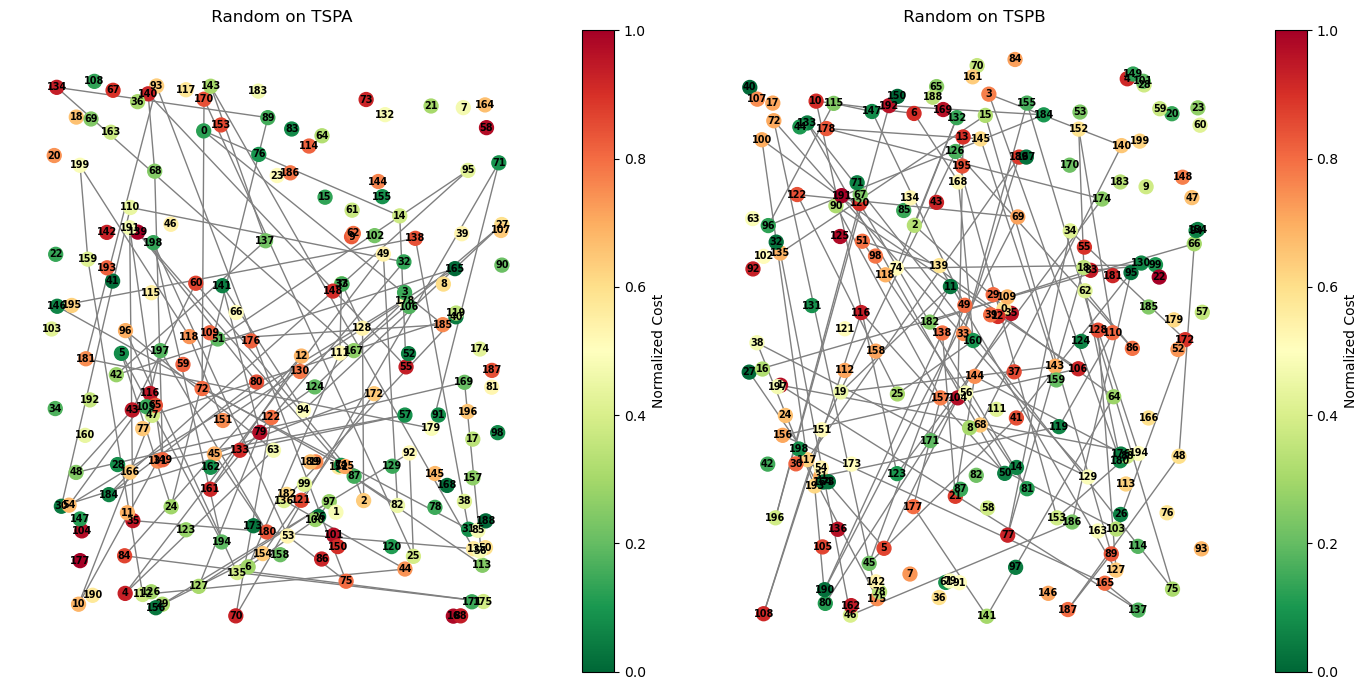

In [5]:
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)
cmap = plt.cm.get_cmap('RdYlGn_r')

for count, method in enumerate(methods):
    if count == len(best_solutions) // 2:
        break
    print(method)
    print('TSPA')
    print(best_solutions[count])
    print(count, count + len(best_solutions)//2)
    print('TSPB')
    print(best_solutions[count + len(best_solutions)//2])

    fig, axs = plt.subplots(1, 2, figsize=(14, 7))

    for count, sol in enumerate([best_solutions[count], best_solutions[count + len(best_solutions)//2]]):
        if count == 0:
            df_temp = dfTSPA
            ax = axs[0]
            instance = 'TSPA'
        else:
            df_temp = dfTSPB
            ax = axs[1]
            instance = 'TSPB'

        G = nx.Graph()
        positions = {}

        for idx in sol:
            G.add_node(idx, size=df_temp.loc[idx, 'Normalized_Cost'])
            positions[idx] = (df_temp.loc[idx, 'X'], df_temp.loc[idx, 'Y'])

        for idx in [i for i in range(0,200) if i not in sol]:
            G.add_node(idx, size=df_temp.loc[idx, 'Normalized_Cost'])
            positions[idx] = (df_temp.loc[idx, 'X'], df_temp.loc[idx, 'Y'])

        for i in range(len(sol) - 1):
            G.add_edge(sol[i], sol[i + 1])
        G.add_edge(sol[-1], sol[0])


        normalized_costs = df_temp['Normalized_Cost']
        norm = mcolors.Normalize(vmin=normalized_costs.min(), vmax=normalized_costs.max())
        node_colors = [cmap(norm(df_temp.loc[idx, 'Normalized_Cost'])) for idx in range(0, 200)]

        nx.draw(G, pos=positions, with_labels=True, node_color=node_colors, node_size=100,
            font_size=7, edge_color='gray', linewidths=1, font_weight='bold', ax=ax)

        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Normalized Cost')

        ax.set_title(f" {method} on {instance}")

    plt.tight_layout()
    plt.show()

## Additional Information

### Solution checker

We have checked all of the best solutions via the solution checker provided.

### Source code link

The source code is available in a repository [here](https://github.com/Mickeyo0o/EvolutionaryComp/tree/main/Lab5) under the Lab5 folder.

## Conclusions

The use of deltas from previous iterations was successfully able to lower the time of the Local Search algorithm by approximately 5 times, while loosing very minimal objective function score. The time savings result from leveraging previously computed deltas and updating them incrementally, rather than recalculating the objective function for all candidate moves in every iteration.

## Authors

* Kajetan Sulwiński 151954
* Mikołaj Marmurowicz 151956